In [1]:
#Goal of this document is to do some hacking on augpipelines and other data loading stuff from self-supervised
#and fastai if necessary. This is a big part of point (0) after all!

#Building / continuing from SL_library_dataloading, we consider BT from here: https://keremturgutlu.github.io/self_supervised/14%20-%20barlow_twins.html
#and here https://keremturgutlu.github.io/self_supervised/14%20-%20barlow_twins.html#BarlowTwinsModel

In [2]:
import fastai
fastai.__version__

'2.6.3'

In [3]:
import torch
torch.__version__

/Users/hamishhaggerty/opt/anaconda3/envs/old_fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.11.0'

In [4]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect

#These are imports

In [5]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz

class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))
    
    
#Nothing much to this: Just a simple API for the BT model, with inputs encoder and projector. 


In [6]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 


#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [7]:
#You can use self_supervised.layers module to create an encoder. 

encoder = create_encoder("tf_efficientnet_b0_ns",n_in=3,pretrained=False,pool_type=PoolingType.CatAvgMax)
model = create_barlow_twins_model(encoder,hidden_size=2048,projection_size=128,nlayers=2)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

In [8]:
get_multi_aug_pipelines

<function self_supervised.augmentations.get_multi_aug_pipelines(n, size, rotate=True, jitter=True, bw=True, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3, stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), cuda=False, xtra_tfms=[])>

In [9]:
#Ok, we want to understand get_multi_aug_pipelines. The below is copy pasted from GitHub:

#Note that when we uncomment and run this cell, some things below break. Just something to keep in mind. 

#So get_multi... is just get_batch_augs (called twice in a list).

#So we need to understand get_batch_augs. We go through the arguments:

# Cell
# def get_batch_augs(size, #This is 28 for current dataset below. So if image is 28x28, size=28. 
#                     rotate=True, #This is obvious
#                     jitter=True, #Looking below, this seems to require color,
#                     bw=True, # Looking at torchvision docs for RandomGrayscale: " ... If the image is torch Tensor, it is expected to have […, 3, H, W] shape, where … means an arbitrary number of leading dimensions"
#                              #of course here it is kornia but presumably the same in this respect

                      #blur=True, 
#                     resize_scale=(0.2, 1.0),
#                     resize_ratio=(3/4, 4/3),
#                     rotate_deg=30,
#                     jitter_s=.6,
#                     blur_s=(4,32),
#                     same_on_batch=False,
#                     flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3,
#                     stats=imagenet_stats,
#                     cuda=default_device().type == 'cuda',
#                     xtra_tfms=[]):
#     "Input batch augmentations implemented in tv+kornia+fastai"
#     tfms = []
#     tfms += [tvtfm.RandomResizedCrop((size, size), scale=resize_scale, ratio=resize_ratio)]
#     tfms += [korniatfm.RandomHorizontalFlip(p=flip_p)]

#     if rotate: tfms += [Rotate(max_deg=rotate_deg, p=rotate_p, batch=same_on_batch)]

#     if jitter: tfms += [korniatfm.ColorJitter(0.8*jitter_s, 0.8*jitter_s, 0.8*jitter_s, 0.2*jitter_s, p=jitter_p, same_on_batch=same_on_batch)]
#     if bw:     tfms += [korniatfm.RandomGrayscale(p=bw_p, same_on_batch=same_on_batch)]
#     if blur:   tfms += [RandomGaussianBlur(p=blur_p, s=blur_s, same_on_batch=same_on_batch)]

#     if stats is not None: tfms += [Normalize.from_stats(*stats, cuda=cuda)]

#     tfms += xtra_tfms
#     pipe = Pipeline(tfms, split_idx = 0)
#     return pipe

# # Cell
# @delegates(get_batch_augs)
# def get_multi_aug_pipelines(n, size, **kwargs): return [get_batch_augs(size, **kwargs) for i in range(n)]



In [10]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [11]:
aug_pipelines = get_barlow_twins_aug_pipelines(size=28,rotate=False,jitter=False,bw=False,blur=False,stats=None,cuda=False)
aug_pipelines

print(inspect.signature(get_barlow_twins_aug_pipelines)) #If we comment out @delegates above, then only size is printed
                                                         #here; i.e. just prints **kwargs instead of all the actual 
                                                         #keyword arguments!


(size, rotate=True, jitter=True, bw=True, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3, stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), cuda=False, xtra_tfms=[])


In [12]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
    
    #loss function for BT. This is where the action is at: and potentially where I can make my edits...
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [13]:
#Example usage:
bs=32
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [14]:
create_encoder

<function self_supervised.layers.create_encoder(arch: str, pretrained=True, n_in=3, pool_type='catavgmax')>

In [15]:
#Let's just explore cropping / resizing first. This cell currently imposes "do nothing"

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing

#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=False,flip_p=0,resize_scale=(1,1), jitter=False, bw=False, blur=False, stats=None, cuda=False)

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=4)




Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


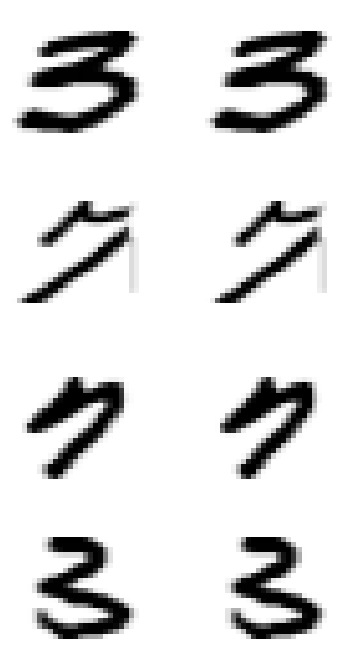

In [65]:
#Contin: let's find reasonable looking cropping / resizing

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing

#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=False,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False, blur=False, stats=None, cuda=False)

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=4)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1, 's': 8, 'same_on_batch': False}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 1, 's': 8, 'same_on_batch': False}


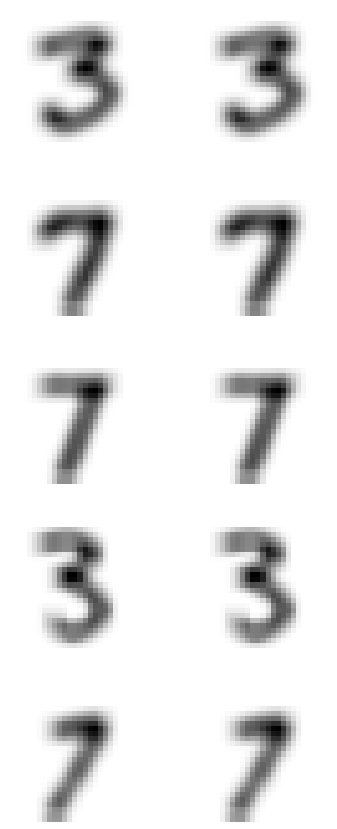

In [75]:
#Next step: let's explore gaussian blur. Keep blur_p=1. Vary blur_s

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)

#RandomGaussianBlur essentially takes in two args: p the probability of applying thr transformation and 
#s which is the value. Here written as p=blur_p, s=blur_s. When we set blur_p=1 and blur_s=1 then it 
#appears to be equivalent to "do nothing". When we set blur_s=0.001
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=False,flip_p=0,resize_scale=(1,1), jitter=False, bw=False, blur=True,blur_p=1,blur_s=8, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=5)


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.2, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.2, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


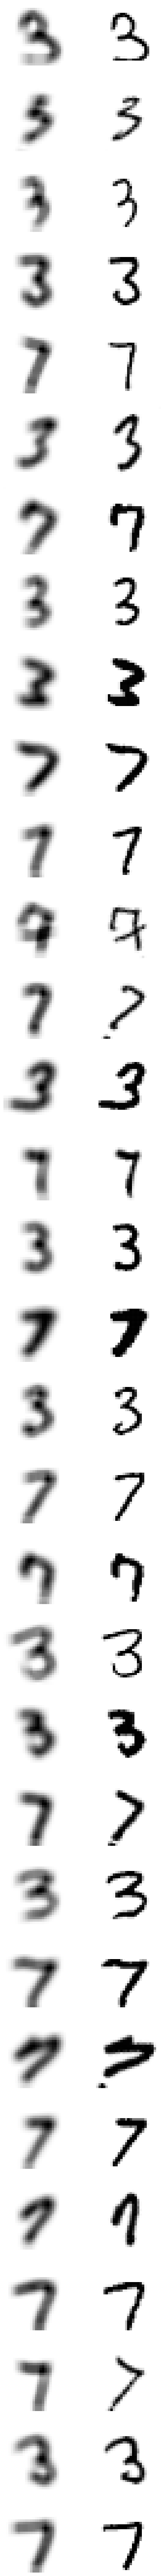

In [82]:
#Let's explore rotation

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing

#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(1,1), jitter=False, bw=False, blur=False, stats=None, cuda=False)

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=4)




Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.8, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.8, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


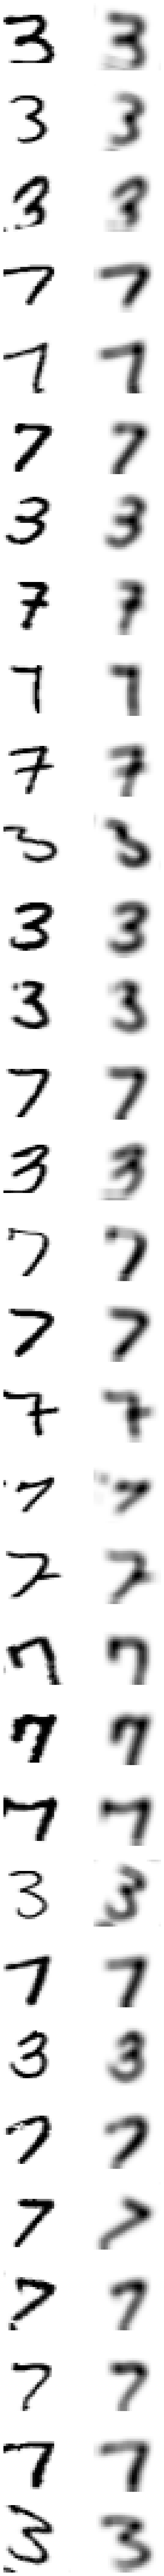

In [93]:
#Let's build a reasonable composite augmentation

fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=1024, projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing

#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)

learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True),ShortEpochCallback(0.001)])
b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=32)
